## Implementing Physics Informed Neural Networks (PINNs)

**Objective**: Implement and analyze a Physics-Informed Neural Network (PINN) that uses a two-layer Multilayer Perceptron (MLP) to solve a specified first-order elliptic Partial Differential Equation (PDE) subject to appropriate boundary conditions.


**Background**: Physics-Informed Neural Networks integrate differential equations that govern physical laws directly into the learning process, allowing the network to not only fit given data but also satisfy the known physical laws. PINNs are particularly useful for solving complex PDEs where traditional numerical methods might be challenging to implement.

Let's focus on first-order elliptic PDE's (which are of course common in various areas of physics and engineering, such as heat transfer, fluid dynamics, and electromagnetism).

Ref: https://www.sciencedirect.com/science/article/pii/S0021999118307125.

We consider the following first-order elliptic PDE over a domain $\Omega$:
$$-\nabla\cdot(a(x)\nabla u(x)) = f(x), x\in\Omega$$
$$u(x) = g(x), x\in\partial \Omega$$

We have $u(x)\in\mathbb{R}, x\in\mathbb{R}^2, a(x) = x^T x$, $f(x) = \sin(x^T x), g(x) = x^T x$, and $\Omega = [0,1]\times[0,1]$ is a unit cube.

PINNs minimize the residual loss given as:

$$\mathcal{L}_{residual} = E_{x\in\Omega}\|-\nabla\cdot(a(x)\nabla u_{\theta}(x)) - f(x)\| + E_{x\in\partial\Omega}\|u_{\theta}(x) - g(x)\|$$

where $\theta$ is your neural network's parameters.

Now, we define a two layer MLP for this PDE, and sample $100, 1000,$ and $10000$ points in $\Omega$ and $100, 1000,$ and $10000$ points in $\partial\Omega$, in total $200, 2000,$ and $20000$ points to approximate the PDE residuals.

The samples can be generated by uniformly by sampling on the boundary $\partial\Omega$ and inside the domain $\Omega$.

Notice that the PINN's performance improve as you increase the number of samples used to calculate the PDE residuals.

We'll also visualize it on the unit cube.

Training with 100 boundary samples and 100 interior samples:
Epoch 0, Loss: 4.705550670623779
Epoch 100, Loss: 0.3261995315551758
Epoch 200, Loss: 0.3239489793777466
Epoch 300, Loss: 0.4445911943912506
Epoch 400, Loss: 0.32557743787765503
Epoch 500, Loss: 0.3829003870487213
Epoch 600, Loss: 0.3179498016834259
Epoch 700, Loss: 0.3283575475215912
Epoch 800, Loss: 0.3116745352745056
Epoch 900, Loss: 0.3213653564453125


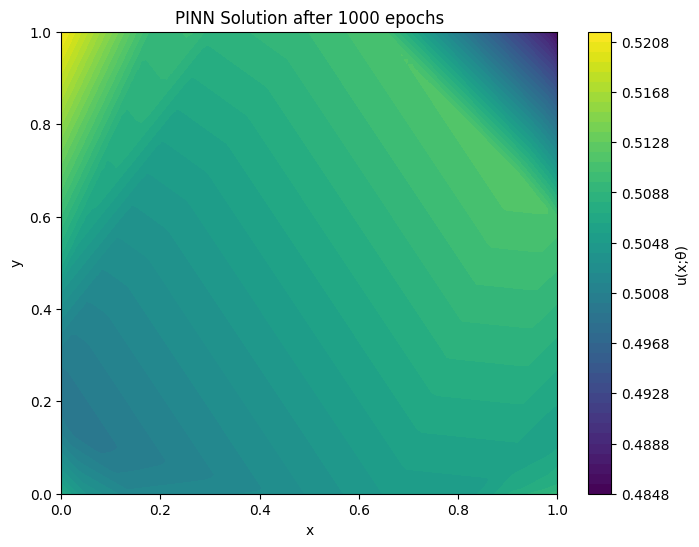

Training with 1000 boundary samples and 1000 interior samples:
Epoch 0, Loss: 700.411376953125
Epoch 100, Loss: 0.4174520969390869
Epoch 200, Loss: 0.6667569279670715
Epoch 300, Loss: 1.318697214126587
Epoch 400, Loss: 2.2913951873779297
Epoch 500, Loss: 0.8207238912582397
Epoch 600, Loss: 0.7835934162139893
Epoch 700, Loss: 0.48742514848709106
Epoch 800, Loss: 0.34622740745544434
Epoch 900, Loss: 0.35271018743515015


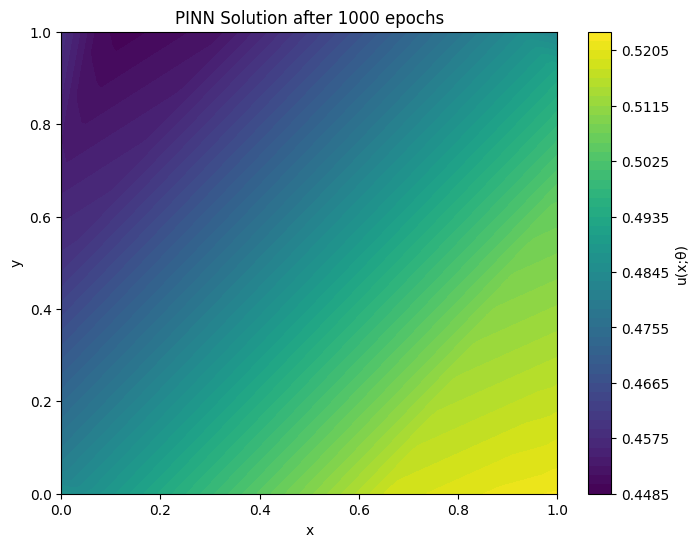

Training with 10000 boundary samples and 10000 interior samples:
Epoch 0, Loss: 126.91075134277344
Epoch 100, Loss: 15.214662551879883
Epoch 200, Loss: 5.014936923980713
Epoch 300, Loss: 2.6909704208374023
Epoch 400, Loss: 1.448683738708496
Epoch 500, Loss: 0.9715043902397156
Epoch 600, Loss: 0.7160727977752686
Epoch 700, Loss: 0.6144193410873413
Epoch 800, Loss: 0.4269932210445404
Epoch 900, Loss: 0.470092236995697


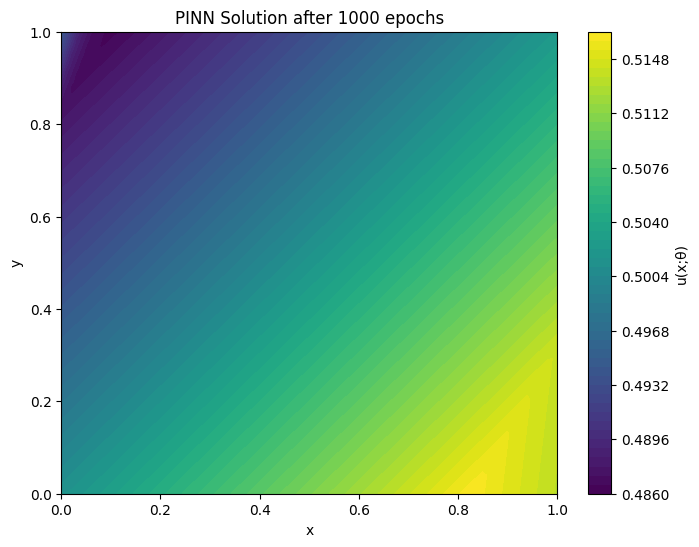

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the two-layer MLP model
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Define the coefficient function a(x) = x^T x
def a_func(x):
    return torch.matmul(x, x.T)

# Define the source term f(x) = sin(x^T x)
def f_func(x):
    return torch.sin(torch.matmul(x, x.T))

# Define the boundary condition function g(x) = x^T x
def g_func(x):
    return torch.matmul(x, x.T)

# Define the PDE residual
def pde_residual(model, x, a_func, f_func):
    # Compute u and its gradients
    x.requires_grad = True
    u = model(x)
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Compute the PDE residual
    residual = torch.div(torch.matmul(a_func(x), grad_u), torch.norm(x, dim=1, keepdim=True)**2).sum(dim=1) - f_func(x)

    return residual

# Define the loss function
def loss_function(model, x_boundary, x_interior, a_func, f_func, g_func):
    # Loss for boundary conditions
    u_boundary = model(x_boundary)
    loss_boundary = torch.mean((u_boundary - g_func(x_boundary))**2)

    # Loss for PDE residual
    residual_interior = pde_residual(model, x_interior, a_func, f_func)
    loss_residual = torch.mean(residual_interior**2)

    return loss_boundary + loss_residual

# Training function
def train_model(model, optimizer, epochs, x_boundary, x_interior, a_func, f_func, g_func, plot=True):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, x_boundary, x_interior, a_func, f_func, g_func)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Plot the PINN solution
    if plot:
        # Define the grid points for visualization
        x = np.linspace(0, 1, 100)
        y = np.linspace(0, 1, 100)
        X, Y = np.meshgrid(x, y)
        points = np.vstack([X.ravel(), Y.ravel()]).T
        points_tensor = torch.tensor(points, dtype=torch.float32, device=device)

        # Evaluate the PINN at the grid points
        with torch.no_grad():
            u = model(points_tensor).cpu().numpy().reshape(X.shape)

        # Plot the contour plot
        plt.figure(figsize=(8, 6))
        plt.contourf(X, Y, u, levels=50, cmap='viridis')
        plt.colorbar(label='u(x;θ)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'PINN Solution after {epochs} epochs')
        plt.show()

# Generate sample points
def generate_samples(num_samples):
    return torch.rand((num_samples, 2))

# Initialize the model and optimizer
input_size = 2
hidden_size = 50
output_size = 1
model = TwoLayerMLP(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model for different numbers of sample points
num_boundary_samples = [100, 1000, 10000]
num_interior_samples = [100, 1000, 10000]

for num_boundary, num_interior in zip(num_boundary_samples, num_interior_samples):
    print(f"Training with {num_boundary} boundary samples and {num_interior} interior samples:")
    x_boundary = generate_samples(num_boundary)
    x_interior = generate_samples(num_interior)
    train_model(model, optimizer, epochs=1000, x_boundary=x_boundary, x_interior=x_interior, a_func=a_func, f_func=f_func, g_func=g_func)
